# gluonts12-end_dates

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [15]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


In [16]:
dataname = "m4_monthly_end032014"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_end032014.


In [17]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 1807
length test dataset 1807


In [18]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'item_id': 'M3991',
 'target': array([ 1499.,  1677.,  2533.,  1834.,  2922.,  2460.,  2892.,  1969.,
         2781.,  2988.,  3035.,  3172.,  1818.,  2828.,  1979.,  2821.,
         2181.,  2287.,  2320.,  2839.,  1482.,  3094.,  2410.,  2752.,
         1728.,  2112.,  1946.,  2738.,  1812.,  2142.,  2365.,  3492.,
         2875.,  3992.,  1805.,  3433.,  1287.,  2497.,  3733.,  3392.,
         3690.,  4116.,  3163.,  5815.,  4334.,  3794.,  5340.,  7929.,
        15301.,  5824.,  4470.,  7728.,  4461.,  5206.,  5083., 16296.,
         3479.,  3932.,  5383.,  3772.,  3110.,  3995.,  4393.,  5821.,
         5362.,  3344.,  4723.,  4053.,  4007.,  7126.,  3785.,  2627.,
         1963.,  3676.,  5577.,  3394.,  2389.,  1922.,  2924.,  3221.,
         3411.,  4006.,  3108.,  3576.,  2874.,  2759.,  3644.,  3669.,
         4345.,  3471.,  4172.,  3711.,  4095.,  5106.,  6184.,  5464.,
         3786.,  3505.,  4681.,  3651.,  7627.,  55

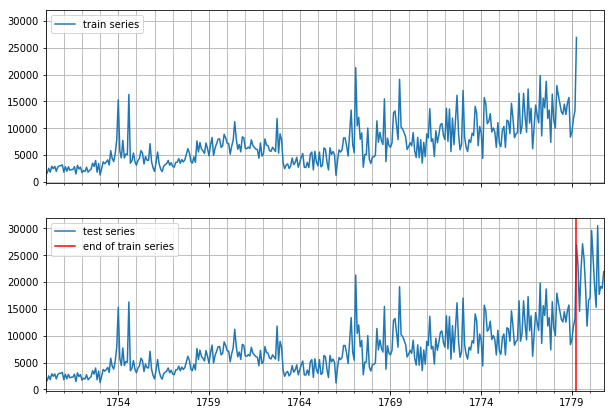

In [19]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [20]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [21]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [22]:
dataname

'm4_monthly_end032014'

In [13]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.25it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 8.917 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835631
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.65it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 7.905 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.265816
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.025 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081766
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.02it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 8.326 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:11<00:00,  8.89it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[72] Elapsed time 11.255 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.588355
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.04it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[73] Elapsed time 8.313 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.602243
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 7.758 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.521852
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.58it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 7.950 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.539460
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.45it/s, avg_epo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.095018  0.186394  16.173892            0.170274            0.133715   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.35it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 9.688 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699839
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 10.927 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.208197
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.63it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 9.417 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.089057
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.30it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 12.054 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_lo

100%|██████████| 100/100 [00:07<00:00, 12.67it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[72] Elapsed time 7.890 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.597689
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.63it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 7.931 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.547988
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 8.733 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491522
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.48it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 8.031 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.573877
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.95it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 8.370

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.113479  0.186524  15.712464            0.173148            0.134562   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.39it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 8.078 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.872864
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.71it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[1] Elapsed time 7.876 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.253729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.95it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 7.727 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.058174
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.77it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 7.834 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[72] Elapsed time 7.750 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.521201
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.92it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 10.084 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.550180
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.54it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 7.976 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.548367
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.86it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 7.776 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.553921
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.98it/s, avg_e

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.214038  0.192075  17.28293            0.184116            0.139715    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.82it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 8.478 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.877563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.62it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 7.922 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.261975
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.222 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.082287
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.06it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 9.937 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[72] Elapsed time 8.020 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.611751
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 7.751 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.533270
INFO:root:Loading parameters from best epoch (43)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:07<00:00, 12.88it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 7.786 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.533245
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:07<00:00, 12.57it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 7.976 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.589262
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|███

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.11054  0.189684  16.741209            0.175028            0.141047    46   

   epochs  num_batches  
0     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.35it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 8.098 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.868606
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.86it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 7.776 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.285495
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.63it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 7.937 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.92it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 7.742 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:10<00:00,  9.89it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[72] Elapsed time 10.119 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.489371
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 8.036 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.525625
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.65it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 7.910 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.582652
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.94it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 7.734 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.563914
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.81it/s, avg_ep

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.128267  0.188297  15.982008            0.175743            0.134602   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.55it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 7.966 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701239
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.77it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 7.853 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.259401
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.85it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 8.462 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.126004
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.80it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 9.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 11.07it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[72] Elapsed time 9.040 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.559569
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[73] Elapsed time 8.725 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.499015
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.92it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 9.168 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.541010
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 8.223 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.553922
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 11.76it/s, avg_epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.198774  0.196303  18.347179            0.183892            0.144892   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.67it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 17.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.826908
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.43it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 13.471 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.310908
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 12.208 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.182963
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 12.409 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.22it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[73] Elapsed time 8.932 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.488250
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.54it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 7.977 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.540201
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.51it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 8.008 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.557754
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.51it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 7.995 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.518074
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.53it/s, avg_epoch_loss=6.55]
IN

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.21926  0.193375  18.095816            0.178724             0.13577    49   

   epochs  num_batches  
0     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.11it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[0] Elapsed time 8.267 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.723833
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.45it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 8.035 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.270346
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.99it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 10.015 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.065984
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.70it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 8.558 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.484912
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[73] Elapsed time 10.783 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.538019
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.48it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 10.560 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.551836
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:11<00:00,  9.04it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 11.071 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.535738
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.10it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 9.909 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.519809
INFO:root:Epoch[77] Learning rate is 0.0005
100%|

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.139888  0.18847  16.218417             0.17639            0.137843    50   

   epochs  num_batches  
0     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.15it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 19.421 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835717
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  5.99it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 16.717 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.262232
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.66it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 15.031 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.057119
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.75it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 17.391 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.544234
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:08<00:00, 11.79it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[73] Elapsed time 8.484 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.516618
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.13it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 9.890 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.480791
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.12it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 10.968 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.503605
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.27it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 9.734 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.566909
INFO:root:Epoch[77] Learning rate is 0.0005
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.132541  0.190542  16.246382            0.176915            0.137895   

   seed  epochs  num_batches  
0    51     100          100  
m4_monthly_end032014


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.095018,0.186394,16.173892,0.170274,0.133715,43,100,100
0,1.113479,0.186524,15.712464,0.173148,0.134562,44,100,100
0,1.214038,0.192075,17.282930,0.184116,0.139715,45,100,100
0,1.110540,0.189684,16.741209,0.175028,0.141047,46,100,100
0,1.128267,0.188297,15.982008,0.175743,0.134602,47,100,100
0,1.198774,0.196303,18.347179,0.183892,0.144892,48,100,100
0,1.219260,0.193375,18.095816,0.178724,0.135770,49,100,100
0,1.139888,0.188470,16.218417,0.176390,0.137843,50,100,100
0,1.132541,0.190542,16.246382,0.176915,0.137895,51,100,100


In [23]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 121513


Seed: 42


100%|██████████| 100/100 [00:02<00:00, 35.45it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 2.822 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.875144
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.91it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[1] Elapsed time 2.639 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.377413
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.45it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 2.672 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.175824
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.66it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 2.588 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.071695
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=7]
INFO:root:Epoch[4] Elapsed time 2.619 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:02<00:00, 38.97it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[37] Elapsed time 2.567 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.647448
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.96it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[38] Elapsed time 2.568 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.557833
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.73it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 2.583 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.620016
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.60it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[40] Elapsed time 2.592 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.638691
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.44it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[41] Elapsed time 2.603 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.46it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[74] Elapsed time 2.602 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.614091
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.25it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 2.616 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.552077
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.65it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 2.589 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.541737
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.36it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 2.608 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.504925
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=6.6]

100%|██████████| 100/100 [00:02<00:00, 38.40it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 2.606 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.518973
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.32it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 2.611 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.524308
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.45it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 2.672 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.464313
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.86it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 2.643 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.503980
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.76it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:02<00:00, 38.78it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[146] Elapsed time 2.580 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.550832
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.21it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[147] Elapsed time 2.619 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.506878
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.64it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 2.589 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.471342
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.14it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[149] Elapsed time 2.623 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.528584
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.92it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[183] Elapsed time 2.596 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.459978
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.43it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[184] Elapsed time 2.673 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.470329
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.80it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 2.647 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.534549
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.03it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 2.631 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.491390
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.51it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.160452  0.196463  17.471643            0.180298            0.141814   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


100%|██████████| 100/100 [00:02<00:00, 36.26it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 2.759 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835631
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 2.633 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.265816
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.26it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 2.615 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081764
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.13it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 2.557 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.969768
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.32it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[4] Elapsed time 2.611 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 38.11it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[37] Elapsed time 2.625 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.573567
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.67it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[38] Elapsed time 2.588 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.637199
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 2.596 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.570863
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 2.606 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.564110
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.07it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[41] Elapsed time 2.628 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.72it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 2.584 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.516730
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.08it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 2.628 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.504979
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.07it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 2.628 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.549049
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.91it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 2.572 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.565662
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████|

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.470861
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.79it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 2.647 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.517859
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.83it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 2.645 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.554961
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.65it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[112] Elapsed time 2.658 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.495886
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.02it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[113] Elapsed time 2.632 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.453131
INFO:root:Epoch[114] Learning rate is 5e-05


100%|██████████| 100/100 [00:02<00:00, 38.80it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[146] Elapsed time 2.578 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.534029
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.16it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[147] Elapsed time 2.555 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.441954
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.57it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 2.594 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.466429
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.35it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[149] Elapsed time 2.609 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.532967
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.77it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.00it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[183] Elapsed time 2.565 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.423760
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.31it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[184] Elapsed time 2.612 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.491640
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.21it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[185] Elapsed time 2.618 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.515175
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.59it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[186] Elapsed time 2.592 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.482283
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.84it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.120709  0.188413  16.535842            0.175331            0.138776   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.780 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699839
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.67it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 2.656 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.208197
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.26it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 2.685 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.089056
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.10it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 2.697 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.965638
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.72it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[4] Elapsed time 2.652 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 38.32it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 2.611 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.618767
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.64it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.589 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.605745
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.02it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 2.632 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.574394
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.86it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 2.642 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.612679
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.04it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 2.630 second

100%|██████████| 100/100 [00:02<00:00, 38.69it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[74] Elapsed time 2.586 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.463980
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.47it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 2.601 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.564490
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.60it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 2.592 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.511937
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.75it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[77] Elapsed time 2.650 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.490545
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.98it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[78] Elapsed time 2.634 se

100%|██████████| 100/100 [00:02<00:00, 38.18it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[110] Elapsed time 2.620 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.561696
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[111] Elapsed time 2.614 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.502795
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.16it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 2.622 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.459513
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 2.611 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.467761
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.68it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[114] E

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.97it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[146] Elapsed time 2.635 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.495539
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[147] Elapsed time 2.633 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.434985
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.94it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 2.637 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.449660
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.85it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[149] Elapsed time 2.644 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.456434
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.58it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.475772
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.21it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[183] Elapsed time 2.619 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.553914
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.67it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[184] Elapsed time 2.587 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.459815
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.02it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[185] Elapsed time 2.564 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.443398
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.24it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[186] Elapsed time 2.616 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.465924
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.094974  0.189488  15.54422            0.173905            0.135166    44   

   epochs  num_batches  
0     200          100  
Seed: 45


100%|██████████| 100/100 [00:02<00:00, 36.61it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 2.733 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.872864
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[1] Elapsed time 2.606 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.253731
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.65it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 2.589 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.058179
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.65it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 2.657 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.981624
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.89it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 2.640 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 39.01it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 2.565 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.622409
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[38] Elapsed time 2.621 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.600573
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.13it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[39] Elapsed time 2.624 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.607060
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.82it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 2.646 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.601751
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.45it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[73] Elapsed time 2.633 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.560917
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.98it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[74] Elapsed time 2.706 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.564851
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.60it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 2.593 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.564672
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.91it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 2.571 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.524412
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.89it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:02<00:00, 38.13it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[109] Elapsed time 2.624 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.573129
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.33it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.611 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.544814
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.69it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 2.586 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.523932
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.57it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[112] Elapsed time 2.594 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.537709
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.63it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 2.590 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.473838
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.15it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[147] Elapsed time 2.693 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.507196
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.30it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 2.613 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.531870
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.96it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[149] Elapsed time 2.636 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.545106
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.33it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.486022
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.44it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[183] Elapsed time 2.603 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.515455
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.49it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[184] Elapsed time 2.599 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.560395
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.79it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[185] Elapsed time 2.580 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.543130
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.61it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.591 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.497033
INFO:root:Epoch[187] Learning rate is 5e-05


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.12721  0.185622  15.920089             0.17454             0.13442    45   

   epochs  num_batches  
0     200          100  
Seed: 46


100%|██████████| 100/100 [00:02<00:00, 36.58it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 2.736 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.877563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 2.595 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.261975
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.83it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 2.645 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.082288
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.39it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 2.676 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.943577
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.19it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[4] Elapsed time 2.620 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 38.17it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 2.621 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.625942
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 2.623 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.633866
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.41it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[39] Elapsed time 2.605 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.606380
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.40it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 2.605 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.651003
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.83it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[41] Elapsed time 2.576 second

100%|██████████| 100/100 [00:02<00:00, 38.45it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 2.602 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.487977
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 2.626 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.546140
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.84it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.644 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.563569
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.60it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[77] Elapsed time 2.592 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.551402
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.78it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[78] Elapsed time 2.580 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.72it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 2.584 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.505202
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.58it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.594 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.492203
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.93it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[113] Elapsed time 2.570 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.453983
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.44it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[114] Elapsed time 2.603 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.494559
INFO:root:Loading parameters from best epoch (104)
INFO:root:Epoch[115] Learning rate is 0.00025
100

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 2.915 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.467523
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.16it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[148] Elapsed time 2.929 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.378347
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.15it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 2.929 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.448230
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.56it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[150] Elapsed time 2.895 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.484446
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.13i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[183] Elapsed time 2.890 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.439729
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.93it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.864 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.483615
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.88it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[185] Elapsed time 2.788 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.460919
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.84it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[186] Elapsed time 2.576 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.345501
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.099734  0.188695  16.61119            0.174206            0.142576    46   

   epochs  num_batches  
0     200          100  
Seed: 47


100%|██████████| 100/100 [00:02<00:00, 36.44it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 2.746 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.868606
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.43it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 2.603 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.285495
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.99it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 2.634 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081828
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.58it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 2.593 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.025494
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.03it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[4] Elapsed time 2.631 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 38.70it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[37] Elapsed time 2.585 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.544717
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.53it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.597 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.613721
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.09it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 2.627 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.619152
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.04it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[40] Elapsed time 2.630 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.581501
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.51it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[41] Elapsed time 2.598 seconds

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.518124
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 2.623 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.576624
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 2.595 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.558050
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.51it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[76] Elapsed time 2.598 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.462915
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.99it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[77] Elapsed time 2.704 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.521

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.554970
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 2.613 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.520160
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.18it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[111] Elapsed time 2.620 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.495589
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.12it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[112] Elapsed time 2.624 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.504303
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.33it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 2.610 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.533853
INFO:root:Epoch[114] Learning rate is 5e-05
1

100%|██████████| 100/100 [00:02<00:00, 38.66it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[146] Elapsed time 2.588 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.493528
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.64it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[147] Elapsed time 2.658 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.513054
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.79it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[148] Elapsed time 2.647 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.509744
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.88it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[149] Elapsed time 2.641 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.574294
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.17it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.90it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[183] Elapsed time 2.640 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.520088
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.05it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[184] Elapsed time 2.630 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.517692
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 2.606 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.528295
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.54it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.596 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.497573
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.58it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.098348  0.189799  15.320322            0.174827             0.13339   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.781 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701239
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 2.626 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.259402
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.63it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 2.732 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.126012
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.30it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 2.612 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.057785
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.38it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[4] Elapsed time 2.677 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:02<00:00, 38.14it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[37] Elapsed time 2.623 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.670824
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.67it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 2.656 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.627992
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.52it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 2.598 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.567244
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.32it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[40] Elapsed time 2.680 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.680360
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.91it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 2.639 second

100%|██████████| 100/100 [00:02<00:00, 37.82it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 2.646 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.531783
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.90it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 2.640 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.535493
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.13it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 2.624 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.552391
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.35it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[77] Elapsed time 2.609 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.513832
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.77it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[78] Elapsed time 2.649 se

100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 2.623 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.534311
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.30it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 2.612 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.525237
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 37.99it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.634 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.490129
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 37.41it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 2.674 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.497535
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:02<00:00, 37.76it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[146] Elapsed time 2.650 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.521557
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[147] Elapsed time 2.595 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.520180
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.56it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 2.594 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.501421
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.87it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[149] Elapsed time 2.642 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.501013
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.07it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.48it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[183] Elapsed time 2.669 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.450785
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.28it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.684 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.482184
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.34it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 2.679 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.528091
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.07it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[186] Elapsed time 2.628 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.522982
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.80it/s, avg_epoch_

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.103891  0.185908  15.87784            0.174731            0.136739    48   

   epochs  num_batches  
0     200          100  
Seed: 49


100%|██████████| 100/100 [00:02<00:00, 35.84it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 2.791 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.826908
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.84it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 2.644 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.310908
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.52it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 2.666 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.182962
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.46it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 2.602 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.983424
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[4] Elapsed time 2.606 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 38.68it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 2.587 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.606077
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.08it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 2.627 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.629535
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.47it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[39] Elapsed time 2.600 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.602988
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.36it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 2.608 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.611325
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.25it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[41] Elapsed time 2.616 seconds

100%|██████████| 100/100 [00:02<00:00, 38.17it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 2.621 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.539978
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.99it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[75] Elapsed time 2.634 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.510331
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.47it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 2.601 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.503628
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.11it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[77] Elapsed time 2.626 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.547207
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.34it/s, avg_epoch_loss

100%|██████████| 100/100 [00:02<00:00, 37.60it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 2.661 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.467499
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.50it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 2.668 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.506652
INFO:root:Loading parameters from best epoch (101)
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.56it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.737 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.492798
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.73it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 2.652 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.411541
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.456398
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.73it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[146] Elapsed time 2.651 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.532619
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 2.626 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.473284
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 2.619 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.443824
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.63it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[149] Elapsed time 2.659 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.492658
INFO:root:Epoch[150] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 38.40it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[182] Elapsed time 2.606 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.444213
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.09it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[183] Elapsed time 2.627 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.445954
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.97it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[184] Elapsed time 2.635 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.426287
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[185] Elapsed time 2.619 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.520767
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.28it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[186] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.158148  0.190415  16.859808            0.175536            0.137528   

   seed  epochs  num_batches  
0    49     200          100  
Seed: 50


100%|██████████| 100/100 [00:02<00:00, 36.09it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[0] Elapsed time 2.772 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.723833
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.78it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 2.648 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.270345
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 2.626 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.065984
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.55it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 2.665 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.999978
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.33it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[4] Elapsed time 2.681 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:02<00:00, 38.03it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 2.631 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.612400
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.28it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[38] Elapsed time 2.614 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.544243
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.96it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 2.635 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.681493
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.68it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 2.655 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.627129
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.31it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[41] Elapsed time 2.612 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.545664
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.45it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 2.602 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.545303
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.71it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[75] Elapsed time 2.585 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.529148
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.62it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 2.659 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.536051
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.87it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[77] Elapsed time 2.642 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.529177
INFO:root:Epoch[78] Learning rate is 0.00025
100

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.25it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[110] Elapsed time 2.616 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.545394
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.07it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[111] Elapsed time 2.628 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.483592
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.30it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 2.612 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.518527
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.53it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 2.597 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.535456
INFO:root:Epoch[114] Learning rate is 5e-05


100%|██████████| 100/100 [00:02<00:00, 37.98it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[146] Elapsed time 2.634 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.540748
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.87it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[147] Elapsed time 2.642 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.525088
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.61it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[148] Elapsed time 2.591 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.517191
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.12it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[149] Elapsed time 2.625 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.471942
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.67it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[183] Elapsed time 2.656 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.533075
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.27it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[184] Elapsed time 2.615 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.457797
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.94it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 2.638 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.496549
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.90it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 2.640 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.514433
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.122988  0.189179  15.949052            0.176572            0.136864   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:02<00:00, 35.28it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 2.837 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835717
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.07it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 2.699 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.262226
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.03it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 2.631 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.057081
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.40it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 2.675 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.936743
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[4] Elapsed time 2.622 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 38.55it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 2.595 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.631066
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[38] Elapsed time 2.633 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.602331
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.46it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 2.601 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.570621
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.83it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 2.645 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.598662
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.97it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[41] Elapsed time 2.635 seco

100%|██████████| 100/100 [00:02<00:00, 38.44it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[73] Elapsed time 2.603 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.575036
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 37.74it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 2.651 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.542502
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 37.89it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 2.640 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.554738
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.07it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[76] Elapsed time 2.628 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.607908
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.42it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.87it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[110] Elapsed time 2.576 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.569419
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.18it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 2.554 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.549688
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.56it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[112] Elapsed time 2.595 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.505927
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.67it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[113] Elapsed time 2.587 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.569781
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.69it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.524637
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.73it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[147] Elapsed time 2.584 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.487151
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.27it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 2.615 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.533965
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.99it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[149] Elapsed time 2.633 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.581748
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.74it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[150] Elapsed time 2.651 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.560034
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 38.38it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[183] Elapsed time 2.607 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.518504
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.91it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 2.571 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.572382
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.74it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 2.582 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.534146
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.50it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 2.599 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.463654
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.10it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.112393  0.186667  15.015276            0.171825            0.134011   

   seed  epochs  num_batches  
0    51     200          100  
m4_monthly_end032014


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.160452,0.196463,17.471643,0.180298,0.141814,42,200,100
0,1.120709,0.188413,16.535842,0.175331,0.138776,43,200,100
0,1.094974,0.189488,15.544220,0.173905,0.135166,44,200,100
0,1.127210,0.185622,15.920089,0.174540,0.134420,45,200,100
0,1.099734,0.188695,16.611190,0.174206,0.142576,46,200,100
0,1.098348,0.189799,15.320322,0.174827,0.133390,47,200,100
0,1.103891,0.185908,15.877840,0.174731,0.136739,48,200,100
0,1.158148,0.190415,16.859808,0.175536,0.137528,49,200,100
0,1.122988,0.189179,15.949052,0.176572,0.136864,50,200,100
0,1.112393,0.186667,15.015276,0.171825,0.134011,51,200,100


In [24]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=113, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 121513


Seed: 42


100%|██████████| 50/50 [00:01<00:00, 34.63it/s, avg_epoch_loss=8.15]
INFO:root:Epoch[0] Elapsed time 1.445 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.151271
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.14it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[1] Elapsed time 1.313 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.599017
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.39it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[2] Elapsed time 1.304 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.487008
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.73it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.292 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267818
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.84it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[4] Elapsed time 1.323 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.71it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[38] Elapsed time 1.327 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.688535
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.23it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 1.310 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.709173
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.48it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[40] Elapsed time 1.301 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.716182
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.85it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 1.323 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.641786
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.47it/s, avg_epoch_loss=6.63]
INFO:root:Ep

100%|██████████| 50/50 [00:01<00:00, 39.06it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[75] Elapsed time 1.282 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.672424
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 39.06it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 1.282 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.550844
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 38.59it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 1.298 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.558845
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 38.07it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[78] Elapsed time 1.315 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.566155
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 38.67it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[79] Elapsed time 1.294 seconds
INFO

100%|██████████| 50/50 [00:01<00:00, 37.68it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 1.328 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.547975
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.25it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[112] Elapsed time 1.308 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.546603
INFO:root:Loading parameters from best epoch (102)
INFO:root:Loading parameters from best epoch (102)
INFO:root:Final loss: 6.506214561462403 (occurred at epoch 102)
INFO:root:End model training
Running evaluation: 100%|██████████| 1807/1807 [00:33<00:00, 53.30it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 121513


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.079744  0.184576  15.411961            0.171482            0.133091   

   seed  epochs  num_batches  
0    42     113           50  
Seed: 43


100%|██████████| 50/50 [00:01<00:00, 35.24it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 1.421 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127494
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.36it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 1.305 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.543767
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.91it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[2] Elapsed time 1.286 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.337388
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.65it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.295 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.194243
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.81it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[4] Elapsed time 1.289 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.85it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[38] Elapsed time 1.322 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.676159
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.41it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 1.303 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.733184
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.09it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 1.315 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.627745
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 36.00it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[41] Elapsed time 1.390 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.678756
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.88it/s, avg_epoch_loss=6.59]
INFO:root:Ep

100%|██████████| 50/50 [00:01<00:00, 38.41it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[75] Elapsed time 1.303 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.614083
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 39.05it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.282 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.678672
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 38.80it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 1.290 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.609830
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 38.77it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[78] Elapsed time 1.291 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.624569
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 39.20it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[79] Elapsed time 1.277 seconds
INFO

100%|██████████| 50/50 [00:01<00:00, 37.97it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[111] Elapsed time 1.318 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.568272
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.35it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[112] Elapsed time 1.305 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.574899
INFO:root:Loading parameters from best epoch (79)
INFO:root:Final loss: 6.461091995239258 (occurred at epoch 79)
INFO:root:End model training
Running evaluation: 100%|██████████| 1807/1807 [00:34<00:00, 52.94it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 121513


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.093344  0.184069  16.941442            0.169563            0.135978   

   seed  epochs  num_batches  
0    43     113           50  
Seed: 44


100%|██████████| 50/50 [00:01<00:00, 35.22it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 1.421 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.006069
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.94it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.392 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.393610
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 39.10it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[2] Elapsed time 1.280 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.237017
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.26it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 1.308 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.179376
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.73it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[4] Elapsed time 1.326 seconds
INFO:root:Epoch[4] Ev

KeyboardInterrupt: 

In [25]:
results

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.079744,0.184576,15.411961,0.171482,0.133091,42,113,50
0,1.093344,0.184069,16.941442,0.169563,0.135978,43,113,50


In [ ]:
results = pd.DataFrame()

for i in range(44, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=113, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## `m4_monthly_end052015`

In [ ]:
dataname = "m4_monthly_end052015"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train)

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=981, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## `m4_monthly_end092007`

In [ ]:
dataname = "m4_monthly_end092007"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train)

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(45, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results